In [6]:

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from data.config import *
from report.dumps import *
from nn.model import model
from nn.funcs import *
from data.dataset import *


In [7]:
def test(ds, verbose=False, phase="Validation"):
    ds.reset()
    hits = 0
    mean_loss = 0
    while not(ds.iter_done()):
        x, y = ds.next()
        o, batch_loss = nn.forward(x, y, train=False)
        print(o)
        hits += batch_hits(o, y)
        mean_loss += np.mean(batch_loss)
        #if verbose:
        #    print("Loss: " + str(mean_loss), " Predicted: " + str(o), " Expected: " + str(y))
    accuracy = float(hits) / float(ds.size)
    mean_loss = float(mean_loss) / float(ds.size)
    if verbose:
        print(phase + " Accuracy: " + str(accuracy) + " Mean Loss " + str(mean_loss))
    return accuracy, mean_loss

In [8]:
def train(nn, hp, val_hist, train_hist, logger):
    cur_epoch = 1
    cur_iter = 1
    for i in range(1, hp.epochs+1):
        train_loss = 0
        hits = 0
        cur_trained = 0
        while not(hp.ds_train.iter_done()):
            x, y = hp.ds_train.next()
            #print(y)
            o, batch_loss = nn.forward(x, y)
            print(y)
            print()
            print(o)
            print('\n\n')
            nn.backward(y, o)
            nn.update(hp.lr)

            hits += batch_hits(o, y)
            cur_trained += len(x)
            train_loss += np.mean(batch_loss)

            if cur_iter % hp.validate_every_no_of_batches == 0:
                train_accuracy = float(hits) / float(cur_trained)
                train_loss = float(train_loss) / float(cur_trained)
                train_hist.add(cur_iter, train_loss, train_accuracy)
                logger.write((cur_epoch, "Training", cur_iter, train_accuracy, train_loss))
                hits = 0
                train_loss = 0

                if hp.ds_val is not None:
                    val_accuracy, val_loss = test(hp.ds_val, True)
                    val_hist.add(cur_iter, val_loss, val_accuracy)
                    logger.write((cur_epoch, "Val", cur_iter, val_accuracy, val_loss))
            cur_iter += 1
        cur_epoch += 1
        hp.ds_train.reset()
    return val_hist

[[-1.34022653]
 [-1.34022653]
 [-1.2833891 ]
 [ 0.02387172]
 [ 0.194384  ]
 [-0.14664056]
 [-1.34022653]
 [-1.39706395]
 [-1.34022653]
 [ 0.42173371]]

[[-0.53478797]
 [-0.38949537]
 [-0.38949537]
 [-0.65431249]
 [-0.66299153]
 [-0.57058544]
 [-0.57058544]
 [-0.44213309]
 [-0.53478797]
 [-0.64657136]]



[[ 0.64908342]
 [ 1.0469454 ]
 [-1.34022653]
 [ 0.99010798]
 [-1.2833891 ]
 [ 1.6721571 ]
 [ 0.25122143]
 [ 0.13754657]
 [ 0.13754657]
 [ 1.27429511]]

[[-0.76094605]
 [-0.81589976]
 [-0.56071883]
 [-0.8056775 ]
 [-0.75891176]
 [-0.53688999]
 [-0.81995044]
 [-0.82181439]
 [-0.82232308]
 [-0.6958554 ]]



[[ 0.36489628]
 [ 0.59224599]
 [ 0.08070915]
 [ 0.42173371]
 [ 0.87643312]
 [ 0.76275827]
 [ 0.76275827]
 [ 0.70592084]
 [ 0.70592084]
 [-1.16971425]]

[[0.19302299]
 [0.1780983 ]
 [0.18118169]
 [0.18213071]
 [0.18213071]
 [0.17555806]
 [0.17409268]
 [0.19302299]
 [0.17988373]
 [0.18639787]]



[[-1.22655167]
 [ 0.47857113]
 [ 0.76275827]
 [-1.34022653]
 [ 0.47857113]
 [-0.14664056]
 [

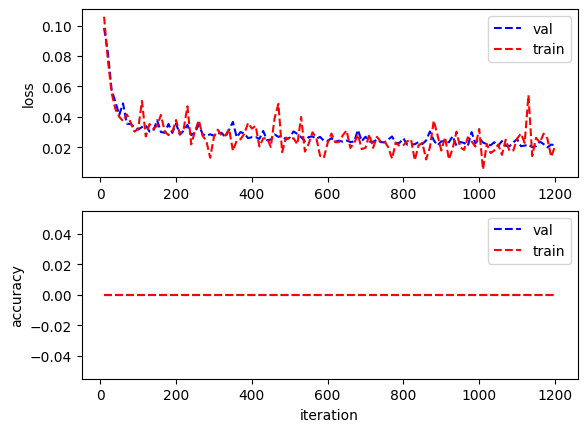

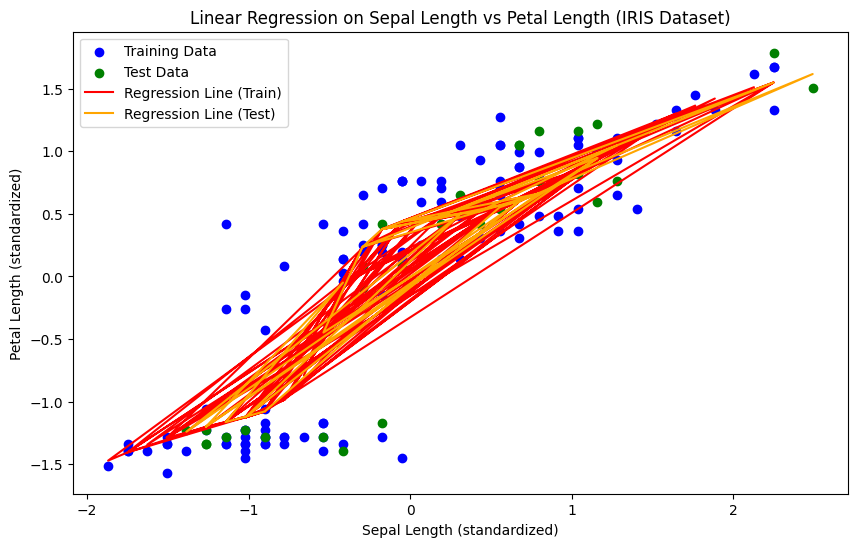

In [9]:
# Load the IRIS dataset
iris = load_iris()
X = iris.data[:, 0].reshape(-1, 1)  # Sepal Length as feature
y = iris.data[:, 2].reshape(-1, 1)  # Petal Length as target

# Standardize the dataset
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use the provided dataset class
batch_size = 10
train_dataset = dataset(X_train, y_train, batch_size)
test_dataset = dataset(X_test, y_test, batch_size)

# Load hyperparameters for the IRIS dataset
hp = hyperparams(ConfigEnum.IRIS)
hp.input_size = 1  # One feature (Sepal Length)
hp.output_size = 1  # One target (Petal Length)
hp.batch_size = batch_size
hp.ds_train = train_dataset
hp.ds_val = test_dataset  # No validation set for simplicity
hp.ds_test = test_dataset
hp.validate_every_no_of_batches = 10
hp.epochs = 100
hp.lr = 0.01
hp.has_dropout = False
hp.hidden_shapes = [10]  # Define some hidden layers if needed

# MSE Loss and Gradient Functions
def mse_loss(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

def mse_loss_grad(y_true, y_pred):
    return -2 * (y_true - y_pred) / y_true.size

# Initialize the model
nn = model(hp.input_size, hp.output_size, hp.hidden_shapes, tanh, tanh_grad, has_dropout=hp.has_dropout, dropout_perc=hp.dropout_perc)
nn.output_activation = lambda x: x  # Identity function
nn.output_activation_grad = lambda x: 1  # Derivative of identity is 1
nn.loss = mse_loss
nn.loss_grad = mse_loss_grad

# Historians and logger
val_hist = historian()
train_hist = historian()
logger = nnlogger(hp.output_log, ("Epoch", "Phase", "Iteration", "Loss"))

# Train the model using the provided train function
train(nn, hp, val_hist, train_hist, logger)

# Wrapper for making predictions without calculating loss
def predict(nn, X, y):
    outputs = []
    # for pair in zip(X, y):
    #     data = pair[0]
    #     y = pair[1]
    o = nn.forward(X, y)
    outputs.append(o[0])
    return np.array(outputs).flatten()

# Test the model using the provided test function and calculate MSE
def test_model(nn, X_test, y_test):
    y_pred = predict(nn, X_test, y_test)
    mse = mse_loss(y_test, y_pred)
    print(f"Test MSE: {mse}")
    return y_pred

# Test the model
y_test_pred = test_model(nn, X_test, y_test)

# Plot results
nnplotter.view(val_hist, train_hist)

# Close logger
logger.close()

# Function to plot the linear regression line
def plot_regression_line(nn, X_train, y_train, X_test, y_test, y_test_pred):
    # Predict outputs for train sets
    y_train_pred = predict(nn, X_train, y_train)
    
    # Plot training data and regression line
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train, y_train, color='blue', label='Training Data')
    plt.scatter(X_test, y_test, color='green', label='Test Data')
    plt.plot(X_train, y_train_pred, color='red', label='Regression Line (Train)')
    plt.plot(X_test, y_test_pred, color='orange', label='Regression Line (Test)')
    plt.xlabel('Sepal Length (standardized)')
    plt.ylabel('Petal Length (standardized)')
    plt.title('Linear Regression on Sepal Length vs Petal Length (IRIS Dataset)')
    plt.legend()
    plt.show()

# Extract training and test data from the dataset class instances
X_train = train_dataset.compl_x
y_train = train_dataset.compl_y
X_test = test_dataset.compl_x
y_test = test_dataset.compl_y


# Plot the regression line
plot_regression_line(nn, X_train, y_train, X_test, y_test, y_test_pred)